In [17]:
# prompt: 위에 있는 parser.add_argument의 default 값 args.argument = default 값 형태로 바꿔줘
from easydict import EasyDict

args = EasyDict()

args.is_training = 1
args.model_id = 'test'
# args.model = 'S_Mamba'
args.model = 'iTransformer'
# args.data = 'custom'

args.root_path = './'
args.data_path = 'a01'

args.features = 'M'
args.target = 'OT'
args.freq = 'h'
args.checkpoints = './checkpoints/'
args.seq_len = 96

args.label_len = 48
args.pred_len = 96
args.enc_in = 7
args.dec_in = 7
args.c_out = 7
args.d_model = 512
args.n_heads = 8
args.e_layers = 2
args.d_layers = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 1
args.distil = True
args.dropout = 0.1
args.embed = 'timeF'
args.activation = 'gelu'
args.output_attention = False
args.do_predict = False
args.num_workers = 10
args.itr = 1
args.train_epochs = 10
args.batch_size = 32
args.patience = 3
args.learning_rate = 0.0001
args.des = 'test'
args.loss = 'MSE'
args.lradj = 'type1'
args.use_amp = False
args.use_gpu = True
args.gpu = 0
args.use_multi_gpu = False
args.devices = '0,1,2,3'
args.exp_name = 'MTSF'
args.channel_independence = False
args.inverse = False
args.class_strategy = 'projection'
args.target_root_path = './data/electricity/'
args.target_data_path = 'electricity.csv'
args.efficient_training = False
args.use_norm = True
args.partial_start_index = 0
args.d_state = 32
args.is_training = 1

args.model_id = 'PEMS04_96_12'
# args.model = '$model_name'
args.data = 'ECG'
args.features = 'M'
args.seq_len = 96
args.pred_len = 12
args.e_layers = 4
args.enc_in = 307
args.dec_in = 307
args.c_out = 307
args.des = 'Exp'
args.d_model = 1024
args.d_ff = 1024
args.learning_rate = 0.0005
args.itr = 1
args.use_norm = 0

In [18]:
!pip install einops -qq
!pip install reformer_pytorch -qq
!pip install wfdb -qq

In [19]:
# import wfdb
# a01 = wfdb.rdsamp("./a01")


In [20]:
# a01[0].shape

In [21]:
import wfdb
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
# from utils.timefeatures import time_features
import warnings

warnings.filterwarnings('ignore')


class Dataset_ECG(Dataset):
  def __init__(self, root_path, flag='train', size=None,
              features='S', data_path='ETTh1.csv',
              target='OT', scale=True, timeenc=0, freq='h'):
      self.seq_len = size[0]
      self.label_len = size[1]#variate 개수
      self.pred_len = size[2]


      assert flag in ['train', 'test', 'val']
      type_map = {'train': 0, 'val': 1, 'test': 2}
      self.set_type = type_map[flag]

      self.features = features #M
      self.target = target
      self.scale = scale
      self.timeenc = timeenc #1
      self.freq = freq

      self.root_path = root_path
      self.data_path = data_path
      self.__read_data__()

  def __read_data__(self):
      self.scaler = StandardScaler()
      data_file = os.path.join(self.root_path, self.data_path)
      a01 = wfdb.rdsamp(data_file)
      a01 = a01[0]
      a01 = a01[:1000]
      data = np.array(a01)
      data = np.reshape(data,(-1,1,1))
      data = data[:,:,0]


      train_ratio = 0.6
      valid_ratio = 0.2
      train_data = data[:int(train_ratio * len(data))]
      valid_data = data[int(train_ratio * len(data)): int((train_ratio + valid_ratio) * len(data))]
      test_data = data[int((train_ratio + valid_ratio) * len(data)):]
      total_data = [train_data, valid_data, test_data]
      data = total_data[self.set_type]

      if self.scale:
          self.scaler.fit(train_data)
          data = self.scaler.transform(data)

      df = pd.DataFrame(data)
      df = df.fillna(method='ffill', limit=len(df)).fillna(method='bfill', limit=len(df)).values

      self.data_x = df
      self.data_y = df

  def __getitem__(self, index):
      s_begin = index # 첫번째 값
      s_end = s_begin + self.seq_len # 시퀸스 끝까지
      r_begin = s_end - self.label_len #라벨링 된 sequence까지
      r_end = r_begin + self.label_len + self.pred_len

      seq_x = self.data_x[s_begin:s_end]
      seq_y = self.data_y[r_begin:r_end]
      # return dec_out[:, -self.pred_len:, :]  # [B, L, D] 와 criterion
      seq_x_mark = torch.zeros((seq_x.shape[0], 1))
      seq_y_mark = torch.zeros((seq_x.shape[0], 1))

      return seq_x, seq_y, seq_x_mark, seq_y_mark

  def __len__(self):
      return len(self.data_x) - self.seq_len - self.pred_len + 1

  def inverse_transform(self, data):
      return self.scaler.inverse_transform(data)



# from data_provider.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Solar, Dataset_PEMS, \
#     Dataset_Pred
from torch.utils.data import DataLoader

data_dict = {
    'ECG' : Dataset_ECG,

}


def data_provider(args,flag):
    Data = data_dict[args.data]
    timeenc = 0 if args.embed != 'timeF' else 1

    if flag == 'test':
        shuffle_flag = False
        drop_last = True
        batch_size = 1  # bsz=1 for evaluation
        freq = args.freq
    elif flag == 'pred':
        shuffle_flag = False
        drop_last = False
        batch_size = 1
        freq = freq
        Data = Dataset_Pred
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size  # bsz for train and valid
        freq = args.freq

    data_set = Data(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq,
    )
    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        # if self.conv_layers is not None:
        #     for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
        #         delta = delta if i == 0 else None
        #         x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
        #         x = conv_layer(x)
        #         attns.append(attn)
        #     x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
        #     attns.append(attn)
        if self.conv_layers is None :
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns
class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn





class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn
import math
import torch
import torch.nn as nn
import numpy as np
from math import sqrt

from reformer_pytorch import LSHSelfAttention
from einops import rearrange

class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask

# @torch.jit.ignore
class FullAttention(nn.Module):
    def __init__(self, mask_flag=False, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape

        scale = 1.0 / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)


class DataEmbedding_inverted(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(c_in, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = x.permute(0, 2, 1)

        # x: [Batch Variate Time]
        if x_mark is None:

            x = self.value_embedding(x)
        else:
            x = self.value_embedding(torch.cat([x, x_mark.permute(0, 2, 1)], 1))
        return self.dropout(x)

In [23]:

class Model(nn.Module):
    """
    Paper link: https://arxiv.org/abs/2310.06625
    """

    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention
        self.use_norm = configs.use_norm
        # Embedding
        self.enc_embedding = DataEmbedding_inverted(configs.seq_len, configs.d_model, configs.embed, configs.freq,
                                                    configs.dropout)
        self.class_strategy = configs.class_strategy
        # Encoder-only architecture
        self.encoder = Encoder(
               [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout,
                                      output_attention=configs.output_attention), configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )
        self.projector = nn.Linear(configs.d_model, configs.pred_len, bias=True)

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        if self.use_norm:
            # Normalization from Non-stationary Transformer
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        _, _, N = x_enc.shape # B L N
        # B: batch_size;    E: d_model;
        # L: seq_len;       S: pred_len;
        # N: number of variate (tokens), can also includes covariates

        # Embedding
        # B L N -> B N E                (B L N -> B L E in the vanilla Transformer)
        enc_out = self.enc_embedding(x_enc, x_mark_enc) # covariates (e.g timestamp) can be also embedded as tokens

        # B N E -> B N E                (B L E -> B L E in the vanilla Transformer)
        # the dimensions of embedded time series has been inverted, and then processed by native attn, layernorm and ffn modules
        enc_out, attns = self.encoder(enc_out, attn_mask=None)

        # B N E -> B N S -> B S N
        dec_out = self.projector(enc_out).permute(0, 2, 1)[:, :, :N] # filter the covariates

        if self.use_norm:
            # De-Normalization from Non-stationary Transformer
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))

        return dec_out


    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
        return dec_out[:, -self.pred_len:, :]  # [B, L, D]

In [24]:
# model = Model(args).float()
# model.load_state_dict(torch.load(". /checkpoint.pth"))
# # model = Model(self.args).float()

In [25]:
# model = model.load_state_dict(torch.load("/content/checkpoints/PEMS04_96_12_iTransformer_ECG_M_ft96_sl48_ll12_pl1024_dm8_nh4_el1_dl1024_df1_fctimeF_ebTrue_dtExp_projection_0/checkpoint.pth"))

In [26]:
# torch.save(model)



class Config:
    def __init__(self, seq_len, pred_len, output_attention, use_norm, d_model,n_heads,enc_in,dec_in, embed, freq,
                 dropout, class_strategy, d_state, d_ff, activation, e_layers,factor):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.output_attention = output_attention
        self.use_norm = use_norm
        self.d_model = d_model
        self.n_heads = n_heads
        self.embed = embed
        self.enc_in = enc_in
        self.dec_in = dec_in
        self.freq = freq
        self.dropout = dropout
        self.class_strategy = class_strategy
        self.d_state = d_state
        self.d_ff = d_ff
        self.activation = activation
        self.e_layers = e_layers
        self.factor = factor

configs = Config(
    seq_len=48,
    pred_len=12,
    output_attention=False,
    use_norm=True,
    d_model=512,
    n_heads=8,
    enc_in=307,
    dec_in=307,
    embed='timeF',
    freq='h',
    dropout=0.1,
    class_strategy='projection',
    d_state=32,
    d_ff=2048,
    activation='gelu',
    e_layers=4,
            factor= 1

)
#

config.py
class Config:
    def __init__(self, is_training, root_path, data_path, model_id, model, data, features,
                 seq_len, pred_len, e_layers, enc_in, dec_in, c_out, des, d_model, d_ff,
                 learning_rate, itr, use_norm,factor):
        self.is_training = is_training
        self.root_path = root_path
        self.data_path = data_path
        self.model_id = model_id
        self.model = model
        self.data = data
        self.features = features
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.e_layers = e_layers
        self.enc_in = enc_in
        self.dec_in = dec_in
        self.c_out = c_out
        self.des = des
        self.d_model = d_model
        self.d_ff = d_ff
        self.learning_rate = learning_rate
        self.itr = itr
        self.use_norm = use_norm
        self.factor = factor

config = Config(
        is_training=1,
        root_path = './physionet.org/files/apnea-ecg/1.0.0'
        data_path = 'a01'
        model_id='PEMS04_48_12',
        model='iTransformer',
        data='ECG',
        features='M',
        seq_len=48,
        pred_len=12,
        e_layers=4,
        enc_in=307,
        dec_in=307,
        c_out=307,
        des='Exp',
        d_model=1024,
        d_ff=1024,
        learning_rate=0.0005,
        itr=1,
        use_norm=0
        factor= 1
    )

In [27]:
import matplotlib.pyplot as plt
#metric 반환함수


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def metric(pred, true):
    mse = MSE(pred, true)

    return  mse


# 학습률 조절, 얼리스탑핑 불러오기, scaler 사용
def adjust_learning_rate(optimizer, epoch, args):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    if args.lradj == 'type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch - 1) // 1))}
    elif args.lradj == 'type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))


class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss



# class StandardScaler():
#     def __init__(self, mean, std):
#         self.mean = mean
#         self.std = std

#     def transform(self, data):
#         return (data - self.mean) / self.std

#     def inverse_transform(self, data):
#         return (data * self.std) + self.mean

def visual(true, preds=None, name='./pic/test.pdf'):
    """
    Results visualization
    """
    plt.figure()
    plt.plot(true, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(preds, label='Prediction', linewidth=2)
    plt.legend()
    plt.savefig(name, bbox_inches='tight')



import os
import torch
# from model import Transformer, Informer, Reformer, Flowformer, Flashformer, \
#     iTransformer, iInformer, iReformer, iFlowformer, iFlashformer, S_Mamba


class Exp_Basic(object):
    def __init__(self, args):
        self.args = args
        self.model_dict = {

            # 'iTransformer': iTransformer,
            'S_Mamba': Model
        }
        self.device = self._acquire_device()
        self.model = self._build_model().to(self.device)

    def _build_model(self):
        raise NotImplementedError
        return None

    def _acquire_device(self):
        if self.args.use_gpu:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(
                self.args.gpu) if not self.args.use_multi_gpu else self.args.devices
            device = torch.device('cuda:{}'.format(self.args.gpu))
            print('Use GPU: cuda:{}'.format(self.args.gpu))
        else:
            device = torch.device('cpu')
            print('Use CPU')
        return device

    def _get_data(self):
        pass

    def vali(self):
        pass

    def train(self):
        pass

    def test(self):
        pass


import random

# from data_provider.data_factory import data_provider
# from experiments.exp_basic import Exp_Basic
# from utils.tools import EarlyStopping, adjust_learning_rate, visual
# from utils.metrics import metric
import torch
import torch.nn as nn
from torch import optim
import os
import time
import warnings
import numpy as np

warnings.filterwarnings('ignore')


class Exp_Long_Term_Forecast(Exp_Basic):
    def __init__(self, args):
        super(Exp_Long_Term_Forecast, self).__init__(args)

    def _build_model(self):
        model = Model(self.args).float()

        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        criterion = nn.MSELoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
      total_loss = []
      self.model.eval()
      with torch.no_grad():
          for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
              batch_x = batch_x.float().to(self.device)
              batch_y = batch_y.float()

              if 'PEMS' in self.args.data or 'ECG' in self.args.data:
                  batch_x_mark = None
                  batch_y_mark = None
              else:
                  batch_x_mark = batch_x_mark.float().to(self.device)
                  batch_y_mark = batch_y_mark.float().to(self.device)

              # decoder input
              dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
              dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
              # encoder - decoder

              if self.args.use_amp == False:
                  if self.args.output_attention:
                      outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                  else:
                      outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
              f_dim = -1 if self.args.features == 'MS' else 0
              outputs = outputs[:, -self.args.pred_len:, f_dim:]
              batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)

              pred = outputs.detach().cpu()
              true = batch_y.detach().cpu()

              loss = criterion(pred, true)

              total_loss.append(loss)
      total_loss = np.average(total_loss)
      self.model.train()
      return total_loss

    def train(self, setting):
        train_data, train_loader = self._get_data(flag='train')
        vali_data, vali_loader = self._get_data(flag='val')
        test_data, test_loader = self._get_data(flag='test')

        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()



        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []

            self.model.train()
            epoch_time = time.time()
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)
                if 'PEMS' in self.args.data or 'ECG' in self.args.data:
                    batch_x_mark = None
                    batch_y_mark = None
                else:
                    batch_x_mark = batch_x_mark.float().to(self.device)
                    batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                # encoder - decoder

                if self.args.use_amp == False:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                    f_dim = -1 if self.args.features == 'MS' else 0
                    outputs = outputs[:, -self.args.pred_len:, f_dim:]
                    batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                    loss = criterion(outputs, batch_y)
                    train_loss.append(loss.item())

                if (i + 1) % 100 == 0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    speed = (time.time() - time_now) / iter_count
                    # print(speed)
                    # allocated_memory = torch.cuda.memory_allocated() / (1024 * 1024 * 1024)
                    # cached_memory = torch.cuda.memory_cached() / (1024 * 1024 * 1024)
                    # total = allocated_memory + cached_memory
                    # print('allocated_memory:', allocated_memory)
                    # print('cached_memory:', cached_memory)
                    # print('total:', total)
                    left_time = speed * ((self.args.train_epochs - epoch) * train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()


                if self.args.use_amp == False:
                    loss.backward()
                    model_optim.step()

            print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
            train_loss = np.average(train_loss)
            vali_loss = self.vali(vali_data, vali_loader, criterion)
            test_loss = self.vali(test_data, test_loader, criterion)

            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss, test_loss))
            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            adjust_learning_rate(model_optim, epoch + 1, self.args)

            # get_cka(self.args, setting, self.model, train_loader, self.device, epoch)

        best_model_path = path + '/' + 'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))

        return self.model

    def test(self, setting, test=0):
        test_data, test_loader = self._get_data(flag='test')
        if test:
            print('loading model')
            self.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

        preds = []
        trues = []
        folder_path = './test_results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)

                if 'PEMS' in self.args.data or 'Solar' in self.args.data:
                    batch_x_mark = None
                    batch_y_mark = None
                else:
                    batch_x_mark = batch_x_mark.float().to(self.device)
                    batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder

                if self.args.use_amp == False:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]

                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                outputs = outputs.detach().cpu().numpy()
                batch_y = batch_y.detach().cpu().numpy()
                if test_data.scale and self.args.inverse:
                    shape = outputs.shape
                    outputs = test_data.inverse_transform(outputs.squeeze(0)).reshape(shape)
                    batch_y = test_data.inverse_transform(batch_y.squeeze(0)).reshape(shape)

                pred = outputs
                true = batch_y

                preds.append(pred)
                trues.append(true)
                if i % 20 == 0:
                    input = batch_x.detach().cpu().numpy()
                    if test_data.scale and self.args.inverse:
                        shape = input.shape
                        input = test_data.inverse_transform(input.squeeze(0)).reshape(shape)
                    gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
                    pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
                    visual(gt, pd, os.path.join(folder_path, str(i) + '.pdf'))

        preds = np.array(preds)
        trues = np.array(trues)
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        # 결과 저장
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        mae, mse, rmse, mape, mspe = metric(preds, trues)
        print('mse:{}, mae:{}'.format(mse, mae))
        f = open("result_long_term_forecast.txt", 'a')
        f.write(setting + "  \n")
        f.write('mse:{}, mae:{}'.format(mse, mae))
        f.write('\n')
        f.write('\n')
        f.close()

        np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path + 'pred.npy', preds)
        np.save(folder_path + 'true.npy', trues)


    def get_input(self, setting):
        test_data, test_loader = self._get_data(flag='test')
        inputs = []
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
            input = batch_x.detach().cpu().numpy()
            inputs.append((input))
        folder_path = './results/' + setting + '/'
        np.save(folder_path + 'input.npy', inputs)

    def predict(self, setting, load=False):
        pred_data, pred_loader = self._get_data(flag='pred')

        if load:
            path = os.path.join(self.args.checkpoints, setting)
            best_model_path = path + '/' + 'checkpoint.pth'
            self.model.load_state_dict(torch.load(best_model_path))

        preds = []

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(pred_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                outputs = outputs.detach().cpu().numpy()
                if pred_data.scale and self.args.inverse:
                    shape = outputs.shape
                    outputs = pred_data.inverse_transform(outputs.squeeze(0)).reshape(shape)
                preds.append(outputs)

        preds = np.array(preds)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        np.save(folder_path + 'real_prediction.npy', preds)

        return


In [28]:
Exp = Exp_Long_Term_Forecast
if args.is_training==1:
  for ii in range(args.itr):
      # setting record of experiments
      setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
          args.model_id,
          args.model,
          args.data,
          args.features,
          args.seq_len,
          args.label_len,
          args.pred_len,
          args.d_model,
          args.n_heads,
          args.e_layers,
          args.d_layers,
          args.d_ff,
          args.factor,
          args.embed,
          args.distil,
          args.des,
          args.class_strategy,ii)

exp = Exp(args)
exp.train(setting)

torch.cuda.empty_cache()

Use GPU: cuda:0
train 493
val 93
test 93
Epoch: 1 cost time: 1.6157755851745605
Epoch: 1, Steps: 15 | Train Loss: 1.6895932 Vali Loss: 0.8365315 Test Loss: 0.8822784
Validation loss decreased (inf --> 0.836532).  Saving model ...
Updating learning rate to 0.0005
Epoch: 2 cost time: 0.6343441009521484
Epoch: 2, Steps: 15 | Train Loss: 1.0116604 Vali Loss: 1.0292950 Test Loss: 0.9605756
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.00025
Epoch: 3 cost time: 0.6572329998016357
Epoch: 3, Steps: 15 | Train Loss: 0.8078095 Vali Loss: 0.6392782 Test Loss: 0.6514677
Validation loss decreased (0.836532 --> 0.639278).  Saving model ...
Updating learning rate to 0.000125
Epoch: 4 cost time: 0.6656756401062012
Epoch: 4, Steps: 15 | Train Loss: 0.6635417 Vali Loss: 0.6958425 Test Loss: 0.6238929
EarlyStopping counter: 1 out of 3
Updating learning rate to 6.25e-05
Epoch: 5 cost time: 0.6328697204589844
Epoch: 5, Steps: 15 | Train Loss: 0.5899734 Vali Loss: 0.5168282 Test Loss: 0.5145

In [31]:
torch.save(exp.model,'itransformer1.pt')

test 93
test shape: (93, 1, 12, 1) (93, 1, 12, 1)
test shape: (93, 12, 1) (93, 12, 1)


TypeError: cannot unpack non-iterable numpy.float32 object

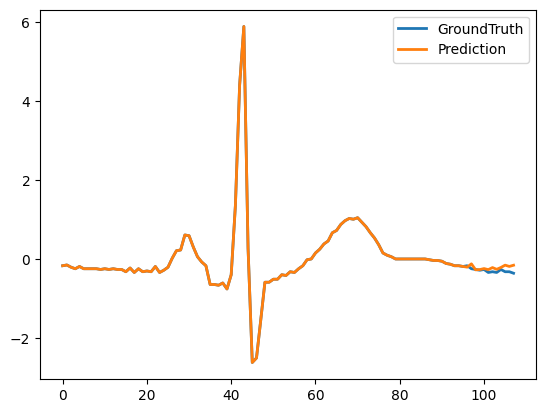

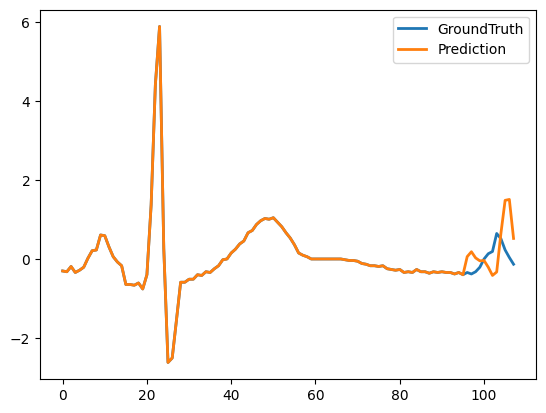

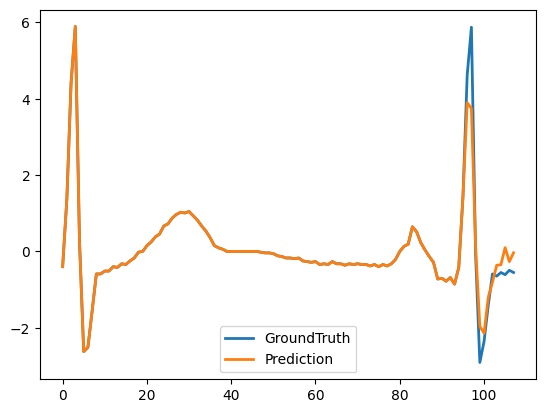

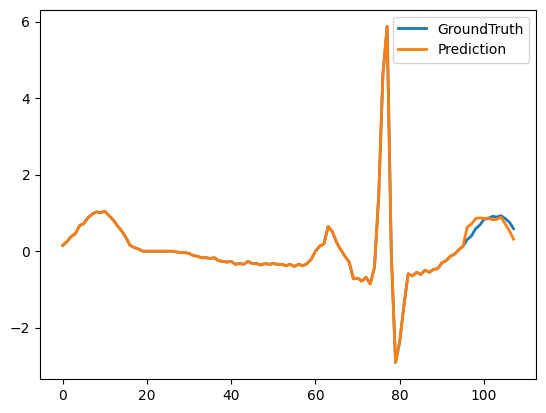

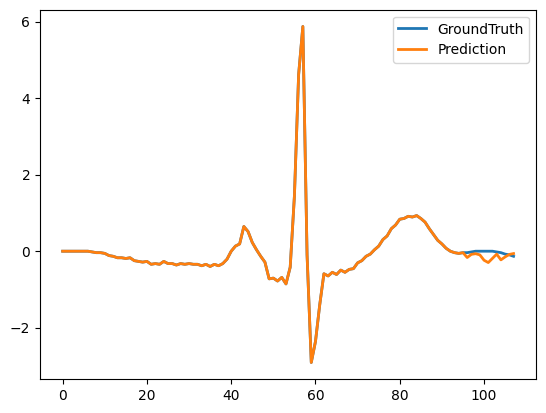

In [30]:
exp.test(setting)




In [45]:
model2 = torch.load('itransformer.pt')

In [48]:
device = 'cuda'
model2.to(device)


Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=1024, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (key_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (value_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (out_projection): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (conv1): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-

In [51]:
model2(x.to(device),None,y.to(device),None)

tensor([[[-0.1355],
         [ 0.3625],
         [ 0.4916],
         [ 0.5621],
         [ 0.1813],
         [ 0.0364],
         [ 0.0025],
         [-0.1204],
         [-0.0425],
         [ 0.1962],
         [-0.0409],
         [ 0.0503]]], device='cuda:0', grad_fn=<SliceBackward0>)

In [50]:
x = torch.zeros_like(torch.randn(1,96,1)).float()
y = torch.zeros_like(torch.randn(1,144,1)).float()



In [ ]:
torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
# encoder - decoder

In [33]:
dataset = Dataset_ECG('./', flag='train', size=[96,48,96],
              features='S', data_path='a01',
              target='OT', scale=True, timeenc=0, freq='h')

In [44]:
for i,(a,b,c,d) in enumerate(dataset):
  print(a.shape)
  print(b.shape)
  print(c.shape)
  print(d.shape)
  if i == 0:
    break


(96, 1)
(144, 1)
torch.Size([96, 1])
torch.Size([96, 1])


In [ ]:


      self.data_x = df
      self.data_y = df
         r_begin            s_end
s_begin   label             seq               pred
# |--------------------------|       seq_x
        #  |---------------------------------|         seq_y
  def __getitem__(self, index):
      s_begin = index # 첫번째 값
      s_end = s_begin + self.seq_len # 시퀸스 끝까지
      r_begin = s_end - self.label_len #라벨링 된 sequence까지
      r_end = r_begin + self.label_len + self.pred_len

      seq_x = self.data_x[s_begin:s_end]
      seq_y = self.data_y[r_begin:r_end]
      # return dec_out[:, -self.pred_len:, :]  # [B, L, D] 와 criterion
      seq_x_mark = torch.zeros((seq_x.shape[0], 1))
      seq_y_mark = torch.zeros((seq_x.shape[0], 1))

      return seq_x, seq_y, seq_x_mark, seq_y_mark


In [ ]:
model2(torch.zeros_like())

In [32]:
preds = []
trues = []
model2.eval()
with torch.no_grad():
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):

        batch_x_mark = None
d
# |--------------------------|     batch_x
        #  |---------------------------------|    batch_y
                            # |---------------| dec_in
          # |-----------------| dec_in

          # decoder input     shape이 96,1임 == batch_x , batch_y = (96+48,1)
                                      # 이지만 2번째 dim에서 진행하는 이유? batchsize가 trainloader시에 새로운 차원으로 추가되기 때문
        dec_inp = torch.zeros_like(batch_y[:, -96:, :]).float()
        dec_inp = torch.cat([batch_y[:, :48, :], dec_inp], dim=1).float().to(device)
          # encoder - decoder



        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

        f_dim = 0
        outputs = outputs[:, -96:, f_dim:]
        batch_y = batch_y[:, -96:, f_dim:].to(device)
        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()


        pred = outputs
        true = batch_y

        preds.append(pred)
        trues.append(true)
        if i % 20 == 0:
            input = batch_x.detach().cpu().numpy()

            gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0) #실제값  concat
            pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)  #예측값 concat

        preds = np.array(preds)
        trues = np.array(trues)
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

shuffle_flag = False
drop_last = True
batch_size = 1  # bsz=1 for evaluation
freq = 'h'

Data = ECG
data_set = Data(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq,
    )
    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader



class Dataset_ECG(Dataset):
  def __init__(self, root_path, flag='train', size=None,
              features='S', data_path='ETTh1.csv',
              target='OT', scale=True, timeenc=0, freq='h'):
      self.seq_len = size[0]
      self.label_len = size[1]#variate 개수
      self.pred_len = size[2]


      assert flag in ['train', 'test', 'val']
      type_map = {'train': 0, 'val': 1, 'test': 2}
      self.set_type = type_map[flag]

      self.features = features #M
      self.target = target
      self.scale = scale
      self.timeenc = timeenc #1
      self.freq = freq

      self.root_path = root_path
      self.data_path = data_path
      self.__read_data__()

  def __read_data__(self):
      self.scaler = StandardScaler()
      data_file = os.path.join(self.root_path, self.data_path)
      a01 = wfdb.rdsamp(data_file)
      a01 = a01[0]
      a01 = a01[:1000]
      data = np.array(a01)
      data = np.reshape(data,(-1,1,1))
      data = data[:,:,0]


      train_ratio = 0.6
      valid_ratio = 0.2
      train_data = data[:int(train_ratio * len(data))]
      valid_data = data[int(train_ratio * len(data)): int((train_ratio + valid_ratio) * len(data))]
      test_data = data[int((train_ratio + valid_ratio) * len(data)):]
      total_data = [train_data, valid_data, test_data]
      data = total_data[self.set_type]

      if self.scale:
          self.scaler.fit(train_data)
          data = self.scaler.transform(data)

      df = pd.DataFrame(data)
      df = df.fillna(method='ffill', limit=len(df)).fillna(method='bfill', limit=len(df)).values

      self.data_x = df
      self.data_y = df

  def __getitem__(self, index):
      s_begin = index # 첫번째 값
      s_end = s_begin + self.seq_len # 시퀸스 끝까지
      r_begin = s_end - self.label_len #라벨링 된 sequence까지
      r_end = r_begin + self.label_len + self.pred_len

      seq_x = self.data_x[s_begin:s_end]
      seq_y = self.data_y[r_begin:r_end]
      # return dec_out[:, -self.pred_len:, :]  # [B, L, D] 와 criterion
      seq_x_mark = torch.zeros((seq_x.shape[0], 1))
      seq_y_mark = torch.zeros((seq_x.shape[0], 1))

      return seq_x, seq_y, seq_x_mark, seq_y_mark

  def __len__(self):
      return len(self.data_x) - self.seq_len - self.pred_len + 1

  def inverse_transform(self, data):
      return self.scaler.inverse_transform(data)


IndentationError: expected an indented block after 'with' statement on line 4 (<ipython-input-32-eb781c6dc5c2>, line 5)